In [ ]:
from google import colab
colab.drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers torch pandas seqeval

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Classroom/Dataset/ner_achami - Sheet1.csv")

df.head()


,Dialect_Text (Target),Entities (Nepali)
0,प्रधानमन्त्री केपी शर्मा ओलीले सिंहदरबारमा नौल...,"केपी शर्मा ओली (PER), सिंहदरबार (LOC)"
1,नेपाल सरकारले आर्थिक वर्ष २०२६/२७ का लागि बजेट...,"नेपाल (LOC), २०२६/२७ (DATE)"
2,काठमाडौँ महानगरपालिकाले दरबारमार्ग नि सडक बना...,"काठमाडौँ महानगरपालिका (ORG), दरबारमार्ग (LOC)"
3,नेपाली कांग्रेसले बुटवलमा आयोजना गर्याको कार्य...,"नेपाली कांग्रेस (ORG), बुटवल (LOC)"
4,गृहमन्त्री रवि लामिछानेले चितवनमा सुरक्षा कसो ...,"रवि लामिछाने (PER), चितवन (LOC)"


In [ ]:
def convert_to_bio(sentence, entity_string):
    tokens = sentence.split()
    bio_labels = ["O"] * len(tokens)

    if pd.isna(entity_string):
        return tokens, bio_labels

    entities = entity_string.split(",")

    for entity in entities:
        entity = entity.strip()
        if "(" not in entity:
            continue

        name, label = entity.split("(")
        name = name.strip()
        label = label.replace(")", "").strip()

        name_tokens = name.split()
        n = len(name_tokens)

        for i in range(len(tokens)):
            match = True

            # Check each token in entity
            for j in range(n):
                if i + j >= len(tokens):
                    match = False
                    break

                # Allow suffix for the last token
                if j == n - 1:
                    if not tokens[i + j].startswith(name_tokens[j]):
                        match = False
                        break
                else:
                    if tokens[i + j] != name_tokens[j]:
                        match = False
                        break

            if match:
                bio_labels[i] = "B-" + label
                for j in range(1, n):
                    bio_labels[i + j] = "I-" + label

    return tokens, bio_labels
sentences = []
true_labels = []

for _, row in df.iterrows():
    tokens, labels = convert_to_bio(row["Dialect_Text (Target)"], row["Entities (Nepali)"])
    sentences.append(tokens)
    true_labels.append(labels)

print(sentences[1])
print(true_labels[1])



['नेपाल', 'सरकारले', 'आर्थिक', 'वर्ष', '२०२६/२७', 'का', 'लागि', 'बजेट', 'प्रस्तुत', 'गर्याको', 'छ।']
['B-LOC', 'O', 'O', 'O', 'B-DATE', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
import pandas as pd

# Convert tokens and labels to space-joined strings
df_save = pd.DataFrame({
    "tokens": [" ".join(tokens) for tokens in sentences],
    "labels": [" ".join(labels) for labels in true_labels]
})

df_save.to_csv("/content/drive/MyDrive/Classroom/Dataset/achhami_translated_ner.csv", index=False)
print("Saved tokenized BIO data to acchami_translated_ner.csv")


Saved tokenized BIO data to acchami_translated_ner.csv


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Classroom/Dataset/achhami_translated_ner.csv")

df.head()

,tokens,labels
0,प्रधानमन्त्री केपी शर्मा ओलीले सिंहदरबारमा नौल...,O B-PER I-PER I-PER B-LOC O O O O O O
1,नेपाल सरकारले आर्थिक वर्ष २०२६/२७ का लागि बजेट...,B-LOC O O O B-DATE O O O O O O
2,काठमाडौँ महानगरपालिकाले दरबारमार्ग नि सडक बनाउ...,B-ORG I-ORG B-LOC O O O O O O O
3,नेपाली कांग्रेसले बुटवलमा आयोजना गर्याको कार्य...,B-ORG I-ORG B-LOC O O O O O O O O O
4,गृहमन्त्री रवि लामिछानेले चितवनमा सुरक्षा कसो ...,O B-PER I-PER B-LOC O O O O O O O


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification

# Nepali NER model
model_name = "SynapseHQ/Finetuned-NER-NepBertA"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)
model.eval()  # evaluation mode

KeyboardInterrupt: 

In [ ]:
def predict_ner(tokens):
    encoding = tokenizer(tokens,
                         is_split_into_words=True,
                         return_tensors="pt",
                         truncation=True)

    with torch.no_grad():
        outputs = model(**encoding)

    predictions = torch.argmax(outputs.logits, dim=2)
    predicted_labels = []

    word_ids = encoding.word_ids()
    previous_word_idx = None

    for idx, word_idx in enumerate(word_ids):
        if word_idx is None:
            continue
        if word_idx != previous_word_idx:
            label_id = predictions[0][idx].item()
            label = model.config.id2label[label_id]
            predicted_labels.append(label)
        previous_word_idx = word_idx

    return predicted_labels


In [ ]:
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score,accuracy_score

all_pred = []
all_true = []

for tokens, labels in zip(sentences, true_labels):
    preds = predict_ner(tokens)

    # Ensure lengths match
    min_len = min(len(preds), len(labels))
    all_pred.append(preds[:min_len])
    all_true.append(labels[:min_len])

# Metrics
print("Precision:", precision_score(all_true, all_pred))
print("Recall:", recall_score(all_true, all_pred))
print("F1 Score:", f1_score(all_true, all_pred))
print("Accuracy:", accuracy_score(all_true, all_pred))

print("\nDetailed Report:\n")
print(classification_report(all_true, all_pred))


Precision: 0.6520833333333333
Recall: 0.5839552238805971
F1 Score: 0.6161417322834646
Accuracy: 0.8484569322892677

Detailed Report:

              precision    recall  f1-score   support

        DATE       0.00      0.00      0.00         7
         LOC       0.75      0.55      0.63       323
        MISC       0.00      0.00      0.00         3
         ORG       0.53      0.78      0.63        87
         PER       0.58      0.59      0.58       116

   micro avg       0.65      0.58      0.62       536
   macro avg       0.37      0.38      0.37       536
weighted avg       0.67      0.58      0.61       536



/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Labels: ['B-DATE', 'B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-DATE', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']


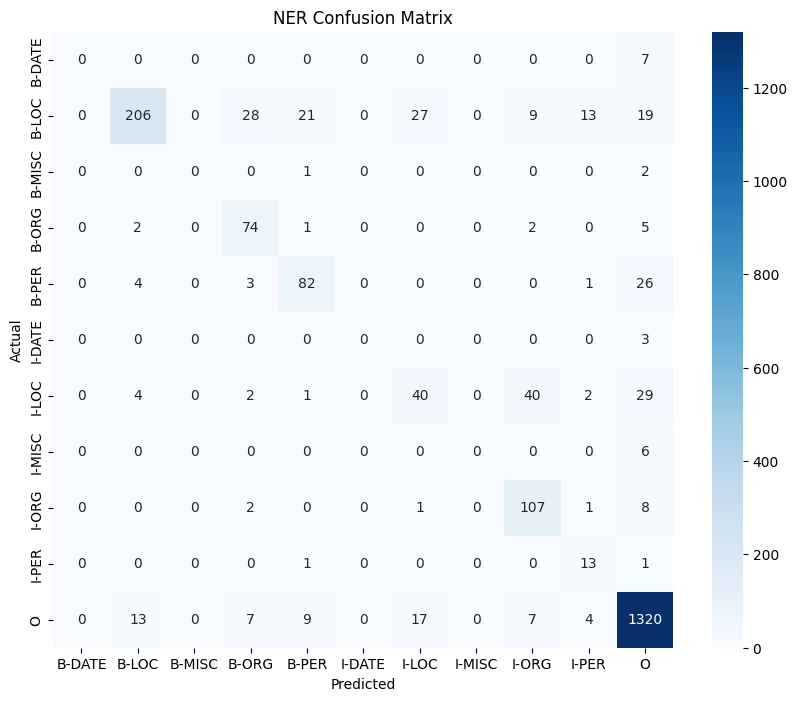

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten token lists
flat_true = [label for seq in all_true for label in seq]
flat_pred = [label for seq in all_pred for label in seq]

# Optional: see unique labels
labels = list(set(flat_true + flat_pred))
labels.sort()  # for consistent ordering
print("Labels:", labels)

cm = confusion_matrix(flat_true, flat_pred, labels=labels)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("NER Confusion Matrix")
plt.show()


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

Precision: 0.6954545454545454
Recall: 0.5708955223880597
F1 Score: 0.6270491803278688
Accuracy: 0.8387839705204975

Detailed Report:

              precision    recall  f1-score   support

        DATE       0.33      0.86      0.48         7
         LOC       0.78      0.56      0.66       323
        MISC       0.14      0.33      0.20         3
         ORG       0.57      0.69      0.62        87
         PER       0.73      0.49      0.59       116

   micro avg       0.70      0.57      0.63       536
   macro avg       0.51      0.59      0.51       536
weighted avg       0.73      0.57      0.63       536

Labels: ['B-DATE', 'B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-DATE', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']


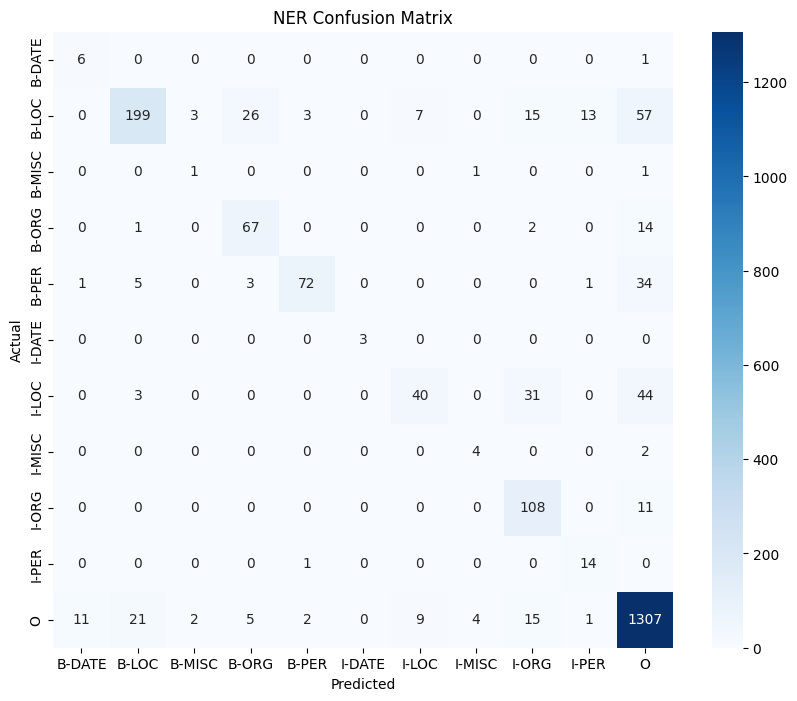

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Nepali NER model
# model_name = "xlm-roberta-base"
model_name= "Saugatkafley/mbert-Nepali-NER"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)
model.eval()  # evaluation mode

def predict_ner(tokens):
    encoding = tokenizer(tokens,
                         is_split_into_words=True,
                         return_tensors="pt",
                         truncation=True)

    with torch.no_grad():
        outputs = model(**encoding)

    predictions = torch.argmax(outputs.logits, dim=2)
    predicted_labels = []

    word_ids = encoding.word_ids()
    previous_word_idx = None

    for idx, word_idx in enumerate(word_ids):
        if word_idx is None:
            continue
        if word_idx != previous_word_idx:
            label_id = predictions[0][idx].item()
            label = model.config.id2label[label_id]
            predicted_labels.append(label)
        previous_word_idx = word_idx

    return predicted_labels

def standardize_labels(labels_list):
    # Mapping from model's predicted labels to dataset's labels
    label_map = {
        'B-Person': 'B-PER',
        'I-Person': 'I-PER',
        'B-Location': 'B-LOC',
        'I-Location': 'I-LOC',
        'B-Organization': 'B-ORG',
        'I-Organization': 'I-ORG',
        'B-Date': 'B-DATE',
        'I-Date': 'I-DATE',
        'B-Event': 'B-MISC', # Assuming Event falls under MISC if not explicitly in true_labels
        'I-Event': 'I-MISC',
        'LABEL_0': 'O',  # Map generic labels to 'O' as they are not standard NER tags
        'LABEL_1': 'O'   # Map generic labels to 'O' as they are not standard NER tags
    }
    return [label_map.get(label, label) for label in labels_list]

# Load the processed data (assuming it's in the current environment or re-loaded)
# If sentences and true_labels are not in the current environment, you would need to re-run the data loading and processing steps.
# For this combined cell, I'll assume `sentences` and `true_labels` are available from previous executions.

# Placeholder for sentences and true_labels if running this cell independently
# If you run this cell in a fresh environment, you'll need to load these first.
# For example:
# df = pd.read_csv("/content/drive/MyDrive/Classroom/Dataset/achhami_translated_ner.csv")
# sentences = [s.split() for s in df['tokens']]
# true_labels = [l.split() for l in df['labels']]


all_pred = []
all_true = []

for tokens, labels in zip(sentences, true_labels):
    preds = predict_ner(tokens)
    # Standardize predicted labels
    preds = standardize_labels(preds)

    # Ensure lengths match
    min_len = min(len(preds), len(labels))
    all_pred.append(preds[:min_len])
    all_true.append(labels[:min_len])

# Metrics
print("Precision:", precision_score(all_true, all_pred))
print("Recall:", recall_score(all_true, all_pred))
print("F1 Score:", f1_score(all_true, all_pred))
print("Accuracy:", accuracy_score(all_true, all_pred))

print("\nDetailed Report:\n")
print(classification_report(all_true, all_pred))

# Flatten token lists
flat_true = [label for seq in all_true for label in seq]
flat_pred = [label for seq in all_pred for label in seq]

# Optional: see unique labels
labels = list(set(flat_true + flat_pred))
labels.sort()  # for consistent ordering
print("Labels:", labels)

cm = confusion_matrix(flat_true, flat_pred, labels=labels)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("NER Confusion Matrix")
plt.show()

## Model Evaluation Results

### Model 1: `SynapseHQ/Finetuned-NER-NepBertA` (from earlier execution)

*   **Precision:** 0.652
*   **Recall:** 0.584
*   **F1 Score:** 0.616
*   **Accuracy:** 0.848

**Detailed Report Micro Average:**

```
              precision    recall  f1-score   support

        DATE       0.00      0.00      0.00         7
         LOC       0.75      0.55      0.63       323
        MISC       0.00      0.00      0.00         3
         ORG       0.53      0.78      0.63        87
         PER       0.58      0.59      0.58       116

   micro avg       0.65      0.58      0.62       536
   macro avg       0.37      0.38      0.37       536
weighted avg       0.67      0.58      0.61       536
```

### Model 2: `Saugatkafley/mbert-Nepali-NER` (from the last execution)

*   **Precision:** 0.695
*   **Recall:** 0.571
*   **F1 Score:** 0.627
*   **Accuracy:** 0.839

**Detailed Report Micro Average:**

```
              precision    recall  f1-score   support

        DATE       0.33      0.86      0.48         7
         LOC       0.78      0.56      0.66       323
        MISC       0.14      0.33      0.20         3
         ORG       0.57      0.69      0.62        87
         PER       0.73      0.49      0.59       116

   micro avg       0.70      0.57      0.63       536
   macro avg       0.51      0.59      0.51       536
weighted avg       0.73      0.57      0.63       536
```